In [1]:
# RUN THIS CELL BEFORE CONTINUING
library(tidyverse)
options(repr.matrix.max.rows = 6)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [57]:
# Download data
hdi_composite_data_raw <- read_csv("https://raw.githubusercontent.com/phoenixjin8/dsci100-group-project/main/data/hdr_composite_index.csv", show_col_types = FALSE)
poverty_rate_data_raw <- read_csv("https://raw.githubusercontent.com/phoenixjin8/dsci100-group-project/main/data/poverty_rate.csv", skip = 4, show_col_types = FALSE)

# Tidy poverty rate data
poverty_rate_data <- poverty_rate_data_raw |>
    select(-country_name, -indicator_name, -indicator_code) |>
    pivot_longer(-country_code, names_to = "year", values_to = "poverty_rate") |>
    filter(!is.na(poverty_rate))

# Tidy HDI data
# Eliminate irrelevant columns
hdi_composite_data_raw <- hdi_composite_data_raw |>
    select(-country, -hdicode, -region, -hdi_rank_2021)
# We will write to a new dataframe rather than edit the existing one since the raw data is horrific to work with
# Extract CO2 emissions data and country codes
hdi_composite_data <- hdi_composite_data_raw |>
    select(iso3, co2_prod_1990:co2_prod_2021) |>
    # Remove all information from column name except the year (change each column name to the last 4 characters of itself, ignore "iso3")
    rename_with(function(x){ifelse(x == "iso3", "iso3", substring(x, nchar(x) - 3))}) |>
    pivot_longer(-iso3, names_to = "year", values_to = "co2_per_capita")
# Extract mean years of schooling data
hdi_composite_data <- merge(hdi_composite_data,
                            (hdi_composite_data_raw |>
                             select(iso3, mys_1990:mys_2021) |>
                             rename_with(function(x){ifelse(x == "iso3", "iso3", substring(x, nchar(x) - 3))}) |>
                             pivot_longer(-iso3, names_to = "year", values_to = "mean_schooling")))
# Extract GNI per capita data
hdi_composite_data <- merge(hdi_composite_data,
                            (hdi_composite_data_raw |>
                             select(iso3, gnipc_1990:gnipc_2021) |>
                             rename_with(function(x){ifelse(x == "iso3", "iso3", substring(x, nchar(x) - 3))}) |>
                             pivot_longer(-iso3, names_to = "year", values_to = "gni_per_capita")))

# Merge HDI data with poverty rate data and convert year to a number
tidy_data <- merge(poverty_rate_data, hdi_composite_data, by.x = c("country_code", "year"), by.y = c("iso3", "year"), all = TRUE) |>
    mutate(year = as.numeric(year))

tidy_data

country_code,year,poverty_rate,co2_per_capita,mean_schooling,gni_per_capita
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AFG,1990,NA,0.20972731,0.9711254,2684.550
AFG,1991,NA,0.18252477,1.0193558,2276.289
AFG,1992,NA,0.09523286,1.0675862,2059.868
⋮,⋮,⋮,⋮,⋮,⋮
ZZK.WORLD,2019,NA,4.560754,8.612013,16652.53
ZZK.WORLD,2020,NA,4.297988,8.635057,15963.89
ZZK.WORLD,2021,NA,4.274185,8.617461,16752.08


Warning message:
“Removed 4 rows containing missing values (geom_point).”


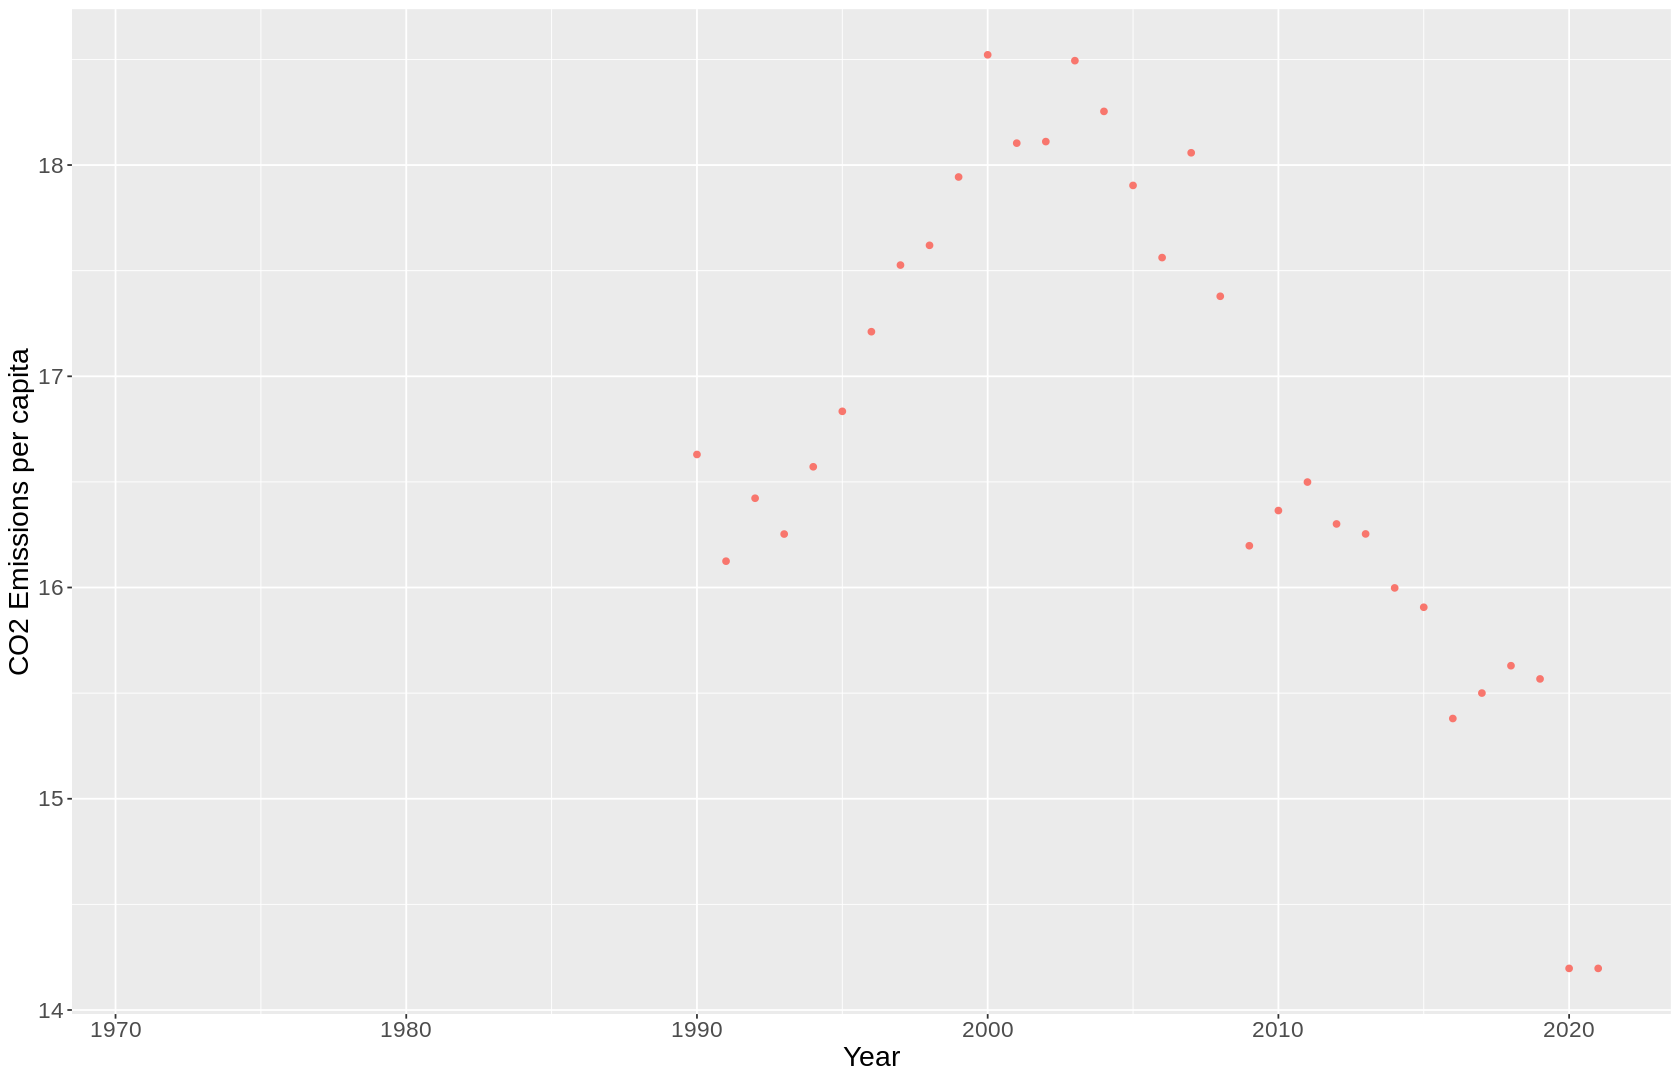

In [56]:
options(repr.plot.width = 14, repr.plot.height = 9)
canada_co2_plot <- filter(tidy_data, country_code == "CAN") |>
    ggplot(aes(x = year, y = co2_per_capita, colour = country_code)) +
    geom_point() +
    labs(x = "Year", y = "CO2 Emissions per capita", colour = "Country") +
    theme(text = element_text(size = 17), legend.position="none")

canada_co2_plot